This notebook showcases how the data for pytorch captioning tutorial was originally obtained.

Running this script is not necessary to complete the basic assignment as __you will be given preprocessed data__ produced by this notebook. The script itself takes hours

However, if one wants to implement e.g. attentive captioning with attention casted into earlier layers in the network OR try a different network architecture, one is invited to change this code at will. 
GPU(s), high-speed internet and ~50G of disc space are recommended.

In [1]:
# Obtaining the data:
# download stuff from http://cocodataset.org/#download
!curl http://images.cocodataset.org/zips/train2017.zip > train2017.zip
!curl http://images.cocodataset.org/zips/val2017.zip > val2017.zip
!curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip > annotations_trainval2017.zip

!unzip annotations_trainval2017.zip
!unzip train2017.zip > log
!unzip val2017.zip > log

In [2]:
# sanity check
!du -h --max-depth=1 .

472K	./.ipynb_checkpoints
796M	./annotations
19G	./train2017
788M	./val2017
52G	.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%env CUDA_VISIBLE_DEVICES=1,2,3
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

env: CUDA_VISIBLE_DEVICES=1,2,3


In [5]:
# you may need to !pip install pycocotools
from torchvision.datasets import coco
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])
coco_train = coco.CocoCaptions("./train2017/", "./annotations/captions_train2017.json", transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=coco_train, batch_size=32, shuffle=False, num_workers=4)

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!


In [6]:
from torchvision.models.inception import Inception3
from warnings import warn
class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x

In [7]:
from torch.utils.model_zoo import load_url
model= BeheadedInception3(transform_input=True)

inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
model.load_state_dict(load_url(inception_url))

model = nn.DataParallel(model.train(False).cuda())

# Sanity check

Test-run NN over one batch. NN labels shouldn't be completely absurd.

NN shapes
before_pool: (32, 2048, 8, 8)
after_pool: (32, 2048)
logits: (32, 1000)
# 0


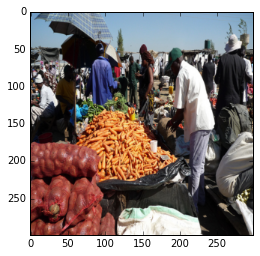

Captions
('People shopping in an open market for vegetables.', 'An open market full of people and piles of vegetables.', 'People are shopping at an open air produce market.', 'Large piles of carrots and potatoes at a crowded outdoor market.', 'People shop for vegetables like carrots and potatoes at an open air market.')
NN classes
['grocery store, grocery, food market, market', 'banana', 'cucumber, cuke', 'ear, spike, capitulum', 'cauliflower']
# 3


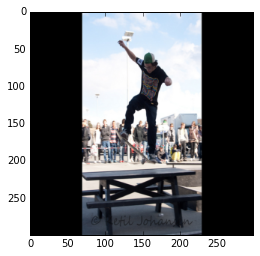

Captions
('The skateboarder is putting on a show using the picnic table as his stage.', 'A skateboarder pulling tricks on top of a picnic table.', 'A man riding on a skateboard on top of a table.', 'A skate boarder doing a trick on a picnic table.', 'A person is riding a skateboard on a picnic table with a crowd watching.')
NN classes
['bannister, banister, balustrade, balusters, handrail', 'stage', 'unicycle, monocycle', 'banjo', 'crane']
# 6


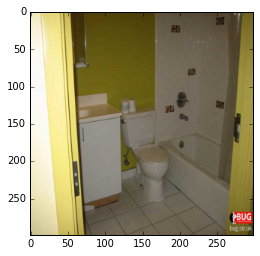

Captions
('A bathroom with a toilet, sink, and bathtub painted yellow and white. ', 'A bathroom interior with a closed toilet and a bathtub.', 'The walls of the small bathroom are painted yellow.', 'Doorway view of a bathroom with sink, toilet and standup shower.', 'A bathroom that has yellow paint and a bathtub a sink and a toilet all in white.')
NN classes
['toilet seat', 'wardrobe, closet, press', 'sliding door', 'washbasin, handbasin, washbowl, lavabo, wash-hand basin', 'bathtub, bathing tub, bath, tub']
# 9


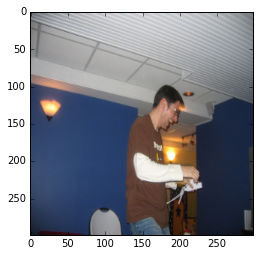

Captions
('A man holding a Wii remote and laughing.', 'a man in a blue walled room playing with a wii mote', 'A man holding a white Wii remote laughs', 'A man laughs to others while playing video games.', 'Man laughing heartily with Wii controller in his left hand')
NN classes
['candle, taper, wax light', 'ping-pong ball', 'spotlight, spot', 'power drill', 'torch']


In [8]:
img_batch, capt_batch = next(iter(data_loader))

# captions batch is transposed in our version. Check if the same is true for yours
capt_batch = list(zip(*capt_batch))
img_batch = Variable(img_batch, volatile=True)
vec_batch_for_attn, vec_batch, logits_batch  = [var.cpu().data.numpy() for var in model(img_batch)]

print("NN shapes")
print('before_pool:', np.shape(vec_batch_for_attn))
print('after_pool:', np.shape(vec_batch))
print('logits:', np.shape(logits_batch))


# class labels
import requests
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

for i in range(0, 10, 3):
    print("#", i)
    plt.imshow(img_batch[i].data.cpu().numpy().transpose([1,2,0]))
    plt.show()
    print('Captions')
    print(capt_batch[i])

    top_ix = (-logits_batch[i]).argsort()
    print('NN classes')
    print(list(map(labels.get, top_ix[:5])))

# Actually transforming data

Note: this part may consume a lot of RAM. If your's a bit limited:
* Do not store vectors that you don't need (e.g. vectors_before_pool if no attention)
* Save everything on a disk every K iterations and free the memory.
    * They ya'll have to manually read it.

In [9]:
from tqdm import tqdm
vectors_before_pool, vectors, logits, captions = [], [], [], []
for img_batch, capt_batch in tqdm(data_loader):
    capt_batch = list(zip(*capt_batch))
    img_batch = Variable(img_batch, volatile=True)
    vec_batch_for_attn, vec_batch, logits_batch  = [var.cpu().data.numpy() for var in model(img_batch)]
    
    
    logits.extend([vec for vec in logits_batch])
    captions.extend(capt_batch)
    vectors.extend([vec for vec in vec_batch])
    
    ## WARNING! If you're low on ram, comment this line.
    vectors_before_pool.extend([vec for vec in vec_batch_for_attn])
    

100%|██████████| 3697/3697 [07:39<00:00,  8.04it/s]


In [11]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

captions_tokenized = [[' '.join(filter(len, tokenizer.tokenize(cap.lower()))) 
                           for cap in img_captions]
                                for img_captions in tqdm(captions)]

100%|██████████| 118287/118287 [00:25<00:00, 4586.81it/s]


In [12]:
i = 123
print("Original:\n%s\n\n" % '\n'.join(captions[i]))
print("Tokenized:\n%s\n\n"% '\n'.join(captions_tokenized[i]))

Original:
A batter and catcher on the mound position for a pitch in a baseball game.
The action at home plate during an organized baseball game.
A baseball player swinging his bat, with the catcher and umpire behind him.
A baseball player getting ready to hit a ball at a game.
A batter at a baseball game who is waiting to be pitched to.


Tokenized:
a batter and catcher on the mound position for a pitch in a baseball game .
the action at home plate during an organized baseball game .
a baseball player swinging his bat , with the catcher and umpire behind him .
a baseball player getting ready to hit a ball at a game .
a batter at a baseball game who is waiting to be pitched to .




# Save everything
May take a couple of minutes depending on hdd/sdd speed.

In [13]:
!mkdir data
np.save("./data/image_codes.npy", np.asarray(vectors))
np.save("./data/image_codes_for_attn.npy", np.asarray(vectors_before_pool))
np.save('./data/image_logits.npy', np.asarray(logits))

import json
with open('./data/captions.json', 'w') as f_cap:
    json.dump(captions, f_cap)
with open('./data/captions_tokenized.json', 'w') as f_cap:
    json.dump(captions_tokenized, f_cap)

In [14]:
# sanity check
!du -h --max-depth=1 .
!ls -lht data

452K	./.ipynb_checkpoints
796M	./annotations
19G	./train2017
60G	./handout
788M	./val2017
112G	.
total 60G
-rw-rw-r-- 1 jheuristic jheuristic  33M мар 17 16:18 captions_tokenized.json
-rw-rw-r-- 1 jheuristic jheuristic  33M мар 17 16:18 captions.json
-rw-rw-r-- 1 jheuristic jheuristic 452M мар 17 16:18 image_logits.npy
-rw-rw-r-- 1 jheuristic jheuristic  58G мар 17 16:18 image_codes_for_attn.npy
-rw-rw-r-- 1 jheuristic jheuristic 925M мар 17 16:15 image_codes.npy
